# This notebook's aim is to explore the available data. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/adventofcode2020/blob/master/adventofcode2020.ipynb)


First, lets import the needed libraries : 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import time

## My script : 
from function import *

In [3]:
# Specific libraries : 
import nltk
#nltk.download()
nltk.download('stopwords')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremynadal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P5-API/'
input_dir = root_dir + 'inputs/'
png_dir = root_dir + 'pngs/'

In [5]:
data = pd.read_csv(input_dir+'posts.csv',parse_dates=[1])

print(data.shape)
print(data.dtypes)
data.head()

(50000, 8)
Id                       int64
CreationDate    datetime64[ns]
Tags                    object
Score                    int64
Title                   object
Body                    object
ViewCount              float64
OwnerUserId            float64
dtype: object


,Id,CreationDate,Tags,Score,Title,Body,ViewCount,OwnerUserId
0,4,2008-07-31 21:42:52,<c#><floating-point><type-conversion><double><...,701,How to convert decimal to double in C#,<p>I want to use a <code>Track-Bar</code> to c...,54136.0,8.0
1,6,2008-07-31 22:08:08,<html><css><internet-explorer-7>,303,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,20627.0,9.0
2,9,2008-07-31 23:40:59,<c#><.net><datetime>,1954,"In C#, how do I calculate someone's age based ...",<p>Given a <code>DateTime</code> representing ...,646489.0,1.0
3,11,2008-07-31 23:55:37,<c#><datetime><time><datediff><relative-time-s...,1563,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,168913.0,1.0
4,13,2008-08-01 00:42:38,<html><browser><timezone><user-agent><timezone...,635,Determine a user's timezone,<p>Is there a standard way for a web server to...,214297.0,9.0


In [6]:
data['Body'][0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type <code>decimal</code> to <code>double</code></p>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

In [50]:
def handle_body(body, tokenizer = nltk.RegexpTokenizer(r'\w+'), stop_words = stopwords.words("english") ):
    soup = BeautifulSoup(body, 'html.parser')
    tokens = tokenizer.tokenize( soup.get_text().lower() )
    result = [ token for token in tokens if not token in stop_words ]
    return result

def handle_tags(tags):
    split = tags.split('><')
    split[0] = split[0][1:]
    split[-1] = split[-1][:-1]
    return split

def get_all_tags(tags):
    res = []
    for i in range(len(tags)):
        for j in range(len(tags[i])):
            res.append(tags[i][j])
            
    return pd.Series(res)

In [23]:
data['Tags'] = data['Tags'].map(handle_tags)

In [24]:
data.head()

,Id,CreationDate,Tags,Score,Title,Body,ViewCount,OwnerUserId
0,4,2008-07-31 21:42:52,"[c#, floating-point, type-conversion, double, ...",701,How to convert decimal to double in C#,<p>I want to use a <code>Track-Bar</code> to c...,54136.0,8.0
1,6,2008-07-31 22:08:08,"[html, css, internet-explorer-7]",303,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,20627.0,9.0
2,9,2008-07-31 23:40:59,"[c#, .net, datetime]",1954,"In C#, how do I calculate someone's age based ...",<p>Given a <code>DateTime</code> representing ...,646489.0,1.0
3,11,2008-07-31 23:55:37,"[c#, datetime, time, datediff, relative-time-s...",1563,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,168913.0,1.0
4,13,2008-08-01 00:42:38,"[html, browser, timezone, user-agent, timezone...",635,Determine a user's timezone,<p>Is there a standard way for a web server to...,214297.0,9.0


In [51]:
tags = get_all_tags(data['Tags'])

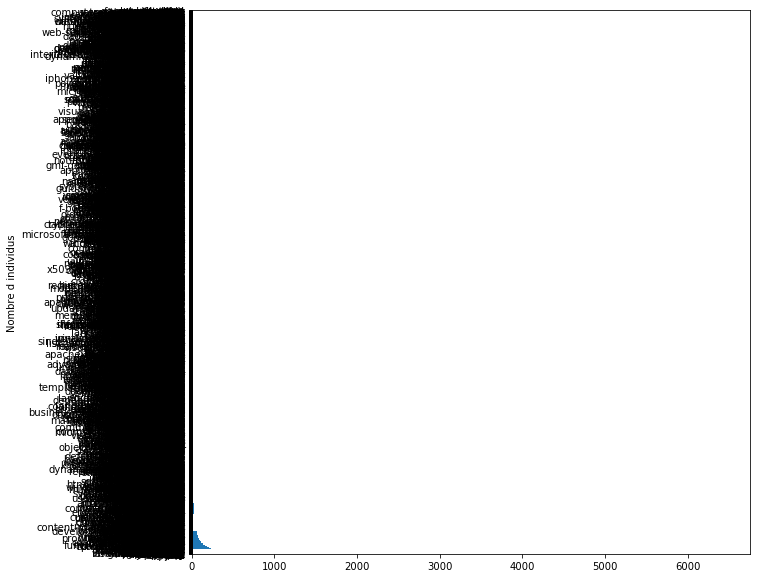

c#                  6432
.net                5168
java                3751
asp.net             3253
c++                 2689
                    ... 
labelfunction          1
face-recognition       1
git-push               1
zend-db-table          1
shtml                  1
Length: 9257, dtype: int64

In [52]:
display_uniques(tags,horiz=True)

In [55]:
data[['Score','ViewCount']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,50000.0,39.336020,229.853834,-8.0,2.0,5.0,15.0,12291.0
ViewCount,49999.0,32594.155763,139747.710359,53.0,1291.0,3877.0,14656.0,4288758.0


In [ ]:
display_uniques(data['Tags'].split('<>'))

In [19]:
handle_tags(data['Tags'][0])

['c#', 'floating-point', 'type-conversion', 'double', 'decimal']

In [37]:
test = data['Tags'][:5]